In [3]:
from collections import defaultdict
import numpy as np
import gymnasium as gym
from tqdm import tqdm

In [4]:
class BlackJackAgent:
    def __init__(self,
                 env: gym.Env,
                learning_rate: float,
                initial_epsilon: float,
                epsilon_decay:float,
                final_epsilon:float,
                discount_factor:float=0.95,                
                ):
        self.env = env
        self.q_values=defaultdict(lambda:np.zeros(env.action_space.n))
        #gives columns of possible moves like (1,0) like that and row of possible observations initially filled with q 
        #later fills with q values
        self.lr=learning_rate
        self.discount_factor=discount_factor
        self.epsilon=initial_epsilon
        self.final_epsilon=final_epsilon
        self.epsilondecay=epsilon_decay
        self.training_error=[]

    #obs = (player_sum, dealer_card, usable_ace)
    #-> function will return an int
    def get_action(self,obs:tuple[int,int,bool])->int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(self,
               obs:tuple[int,int,bool],
               action:int,
               reward:float,
               terminated:bool,
               next_Obs:tuple[int,int,bool]
               ):
        future_q_value=(not terminated)*np.max(self.q_values[next_Obs])
        target=reward+self.discount_factor*future_q_value
        temporal_difference=target-self.q_values[obs][action]
        self.q_values[obs][action]=(
            self.q_values[obs][action]+self.lr*temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon=max(self.final_epsilon,self.epsilon-self.epsilondecay)

In [62]:
lr=0.007
n_episodes=1000000
n_episodes

1000000

In [63]:
start_epsilon=1.0
epsilon_decay=start_epsilon/(n_episodes/2)
epsilon_decay

2e-06

In [64]:
final_epsilon=0.1

In [65]:
env=gym.make("Blackjack-v1",sab=False)

In [66]:
env=gym.wrappers.RecordEpisodeStatistics(env,buffer_length=n_episodes)

In [67]:
agent=BlackJackAgent(
    env,
    lr,
    start_epsilon,
    epsilon_decay,
    final_epsilon
)

In [ ]:
total_rewards=[]
for episode in tqdm(range(10000)):
    obs,info=env.reset()
    done=False
    ep_reward=0
    while not done:
        action=agent.get_action(obs)
        next_obs,reward,terminated,truncated,info=env.step(action)
        agent.update(obs,action,reward,terminated,next_obs)
        done=terminated or truncated
        ep_reward+=reward
        obs=next_obs
    total_rewards.append(ep_reward)
    if episode%10000==0:
        win_rate=np.mean(np.array(total_rewards)>0)
        average_reward=np.mean(total_rewards)
        #print(f"Episodes:{episode}")
        print(f"Win rate:{win_rate}")
        #print(f"Average reward:{average_reward}")
        total_rewards=[]
    agent.decay_epsilon()

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 592/1000000 [00:00<05:39, 2944.08it/s]

Win rate:0.0


  1%|          | 10356/1000000 [00:03<05:06, 3228.29it/s]

Win rate:0.287


  2%|▏         | 20345/1000000 [00:06<04:53, 3342.64it/s]

Win rate:0.2747


  3%|▎         | 30681/1000000 [00:09<04:55, 3282.56it/s]

Win rate:0.2875


  4%|▍         | 40550/1000000 [00:12<04:23, 3639.00it/s]

Win rate:0.289


  5%|▌         | 50572/1000000 [00:15<04:35, 3444.06it/s]

Win rate:0.2953


  6%|▌         | 60581/1000000 [00:18<04:38, 3370.85it/s]

Win rate:0.2964


  7%|▋         | 71610/1000000 [00:21<02:11, 7086.85it/s]

Win rate:0.3034


  8%|▊         | 81437/1000000 [00:22<01:49, 8390.37it/s]

Win rate:0.2987


  9%|▉         | 90948/1000000 [00:23<01:54, 7958.97it/s]

Win rate:0.3072


 10%|█         | 101635/1000000 [00:24<01:40, 8952.95it/s]

Win rate:0.3083


 11%|█         | 110992/1000000 [00:26<01:42, 8681.43it/s]

Win rate:0.3067


 12%|█▏        | 121693/1000000 [00:27<01:40, 8698.09it/s]

Win rate:0.3189


 13%|█▎        | 130910/1000000 [00:28<01:39, 8725.80it/s]

Win rate:0.3154


 14%|█▍        | 141338/1000000 [00:29<01:42, 8381.25it/s]

Win rate:0.3182


 15%|█▌        | 151036/1000000 [00:30<01:37, 8746.00it/s]

Win rate:0.3174


 16%|█▌        | 160899/1000000 [00:32<01:42, 8188.20it/s]

Win rate:0.3261


 17%|█▋        | 171500/1000000 [00:33<01:41, 8193.50it/s]

Win rate:0.3287


 18%|█▊        | 182540/1000000 [00:34<01:35, 8544.52it/s]

Win rate:0.3284


 19%|█▉        | 191818/1000000 [00:35<01:31, 8796.28it/s]

Win rate:0.3371


 20%|██        | 201249/1000000 [00:36<01:43, 7726.36it/s]

Win rate:0.3418


 21%|██        | 211215/1000000 [00:38<01:31, 8596.04it/s]

Win rate:0.3492


 22%|██▏       | 222209/1000000 [00:39<01:34, 8263.59it/s]

Win rate:0.3431


 23%|██▎       | 231905/1000000 [00:40<01:35, 8048.22it/s]

Win rate:0.3471


 24%|██▍       | 241790/1000000 [00:41<01:31, 8292.60it/s]

Win rate:0.3468


 25%|██▌       | 251750/1000000 [00:43<01:38, 7601.06it/s]

Win rate:0.3569


 26%|██▌       | 261723/1000000 [00:44<01:33, 7932.66it/s]

Win rate:0.348


 27%|██▋       | 270798/1000000 [00:45<01:33, 7837.29it/s]

Win rate:0.3482


 28%|██▊       | 281330/1000000 [00:46<01:24, 8489.52it/s]

Win rate:0.3636


 29%|██▉       | 291613/1000000 [00:48<01:35, 7412.39it/s]

Win rate:0.3741


 30%|███       | 301394/1000000 [00:49<01:28, 7897.68it/s]

Win rate:0.3586


 31%|███       | 311647/1000000 [00:50<01:26, 7950.10it/s]

Win rate:0.3725


 32%|███▏      | 321336/1000000 [00:52<01:27, 7749.08it/s]

Win rate:0.3741


 33%|███▎      | 331760/1000000 [00:53<01:19, 8359.03it/s]

Win rate:0.3763


 34%|███▍      | 341829/1000000 [00:54<01:18, 8437.54it/s]

Win rate:0.373


 35%|███▌      | 350843/1000000 [00:55<01:25, 7588.58it/s]

Win rate:0.3744


 36%|███▌      | 360870/1000000 [00:56<01:16, 8305.91it/s]

Win rate:0.3899


 37%|███▋      | 371086/1000000 [00:58<01:23, 7525.10it/s]

Win rate:0.3861


 38%|███▊      | 381742/1000000 [00:59<01:17, 7969.32it/s]

Win rate:0.3919


 39%|███▉      | 391261/1000000 [01:00<01:16, 7985.66it/s]

Win rate:0.3917


 40%|████      | 402002/1000000 [01:02<01:13, 8093.40it/s]

Win rate:0.3935


 41%|████      | 411036/1000000 [01:03<01:03, 9250.49it/s]

Win rate:0.4058


 42%|████▏     | 421273/1000000 [01:04<01:15, 7698.91it/s]

Win rate:0.4013


 43%|████▎     | 430848/1000000 [01:05<01:17, 7362.61it/s]

Win rate:0.3986


 44%|████▍     | 441335/1000000 [01:06<01:04, 8638.59it/s]

Win rate:0.4054


 45%|████▌     | 452429/1000000 [01:08<01:02, 8807.88it/s]

Win rate:0.4114


 46%|████▌     | 461412/1000000 [01:09<01:04, 8403.41it/s]

Win rate:0.4156


 47%|████▋     | 471596/1000000 [01:10<01:10, 7536.43it/s]

Win rate:0.4133


 48%|████▊     | 480852/1000000 [01:11<01:05, 7920.48it/s]

Win rate:0.4164


 49%|████▉     | 491407/1000000 [01:13<00:58, 8664.58it/s]

Win rate:0.4133


 50%|█████     | 501186/1000000 [01:14<01:01, 8076.35it/s]

Win rate:0.4119


 51%|█████     | 511648/1000000 [01:15<01:02, 7826.47it/s]

Win rate:0.4016


 52%|█████▏    | 520882/1000000 [01:16<01:04, 7478.09it/s]

Win rate:0.4128


 53%|█████▎    | 531243/1000000 [01:18<00:59, 7881.32it/s]

Win rate:0.4156


 54%|█████▍    | 541553/1000000 [01:19<00:59, 7670.62it/s]

Win rate:0.4152


 55%|█████▌    | 551134/1000000 [01:20<00:59, 7590.94it/s]

Win rate:0.4113


 56%|█████▌    | 561202/1000000 [01:21<00:54, 8106.60it/s]

Win rate:0.4095


 57%|█████▋    | 571904/1000000 [01:23<00:54, 7919.92it/s]

Win rate:0.4187


 58%|█████▊    | 581829/1000000 [01:24<00:48, 8589.36it/s]

Win rate:0.4185


 59%|█████▉    | 592067/1000000 [01:25<00:48, 8331.00it/s]

Win rate:0.414


 60%|██████    | 601661/1000000 [01:26<00:47, 8353.11it/s]

Win rate:0.4176


 61%|██████    | 610899/1000000 [01:27<00:49, 7867.42it/s]

Win rate:0.4076


 62%|██████▏   | 621302/1000000 [01:29<00:47, 8031.34it/s]

Win rate:0.4143


 63%|██████▎   | 631523/1000000 [01:30<00:46, 7966.56it/s]

Win rate:0.4148


 64%|██████▍   | 641271/1000000 [01:31<00:46, 7719.23it/s]

Win rate:0.411


 65%|██████▌   | 651824/1000000 [01:32<00:38, 8984.67it/s]

Win rate:0.4123


 66%|██████▌   | 660838/1000000 [01:34<00:41, 8086.37it/s]

Win rate:0.4169


 67%|██████▋   | 671244/1000000 [01:35<00:39, 8248.62it/s]

Win rate:0.4123


 68%|██████▊   | 680969/1000000 [01:36<00:39, 8145.06it/s]

Win rate:0.4161


 69%|██████▉   | 691137/1000000 [01:37<00:43, 7181.51it/s]

Win rate:0.4169


 70%|███████   | 701715/1000000 [01:39<00:34, 8627.66it/s]

Win rate:0.4112


 71%|███████   | 711220/1000000 [01:40<00:36, 8004.60it/s]

Win rate:0.4118


 72%|███████▏  | 721180/1000000 [01:41<00:37, 7514.20it/s]

Win rate:0.4207


 73%|███████▎  | 731373/1000000 [01:42<00:34, 7693.40it/s]

Win rate:0.417


 74%|███████▍  | 741338/1000000 [01:44<00:31, 8151.29it/s]

Win rate:0.415


 75%|███████▌  | 751295/1000000 [01:45<00:33, 7328.41it/s]

Win rate:0.4149


 76%|███████▌  | 761662/1000000 [01:46<00:27, 8813.94it/s]

Win rate:0.4014


 77%|███████▋  | 771167/1000000 [01:47<00:29, 7817.90it/s]

Win rate:0.416


 78%|███████▊  | 782105/1000000 [01:49<00:27, 7814.97it/s]

Win rate:0.4194


 79%|███████▉  | 791290/1000000 [01:50<00:26, 7769.14it/s]

Win rate:0.418


 80%|████████  | 801360/1000000 [01:51<00:23, 8375.58it/s]

Win rate:0.4098


 81%|████████  | 810764/1000000 [01:52<00:25, 7438.42it/s]

Win rate:0.4085


 82%|████████▏ | 822155/1000000 [01:54<00:21, 8144.49it/s]

Win rate:0.4134


 83%|████████▎ | 831120/1000000 [01:55<00:21, 7802.06it/s]

Win rate:0.4149


 84%|████████▍ | 841565/1000000 [01:56<00:18, 8439.14it/s]

Win rate:0.4166


 85%|████████▌ | 851125/1000000 [01:57<00:17, 8635.86it/s]

Win rate:0.4158


 86%|████████▌ | 861524/1000000 [01:59<00:16, 8350.45it/s]

Win rate:0.4167


 87%|████████▋ | 872212/1000000 [02:00<00:15, 8330.88it/s]

Win rate:0.4261


 88%|████████▊ | 881167/1000000 [02:01<00:16, 7243.30it/s]

Win rate:0.4071


 89%|████████▉ | 891404/1000000 [02:03<00:12, 8387.37it/s]

Win rate:0.4103


 90%|█████████ | 901601/1000000 [02:04<00:12, 7697.04it/s]

Win rate:0.4141


 91%|█████████ | 912024/1000000 [02:05<00:11, 7454.34it/s]

Win rate:0.4064


 92%|█████████▏| 920845/1000000 [02:07<00:10, 7617.12it/s]

Win rate:0.4185


 93%|█████████▎| 931406/1000000 [02:08<00:08, 7805.44it/s]

Win rate:0.4049


 94%|█████████▍| 941076/1000000 [02:09<00:07, 7914.68it/s]

Win rate:0.4144


 95%|█████████▌| 951547/1000000 [02:10<00:05, 8284.28it/s]

Win rate:0.4072


 96%|█████████▌| 962203/1000000 [02:12<00:04, 7616.50it/s]

Win rate:0.4144


 97%|█████████▋| 971467/1000000 [02:13<00:03, 7410.19it/s]

Win rate:0.4157


 98%|█████████▊| 981208/1000000 [02:14<00:02, 8735.73it/s]

Win rate:0.4158


 99%|█████████▉| 991485/1000000 [02:16<00:01, 7927.49it/s]

Win rate:0.4173


100%|██████████| 1000000/1000000 [02:17<00:00, 7290.70it/s]


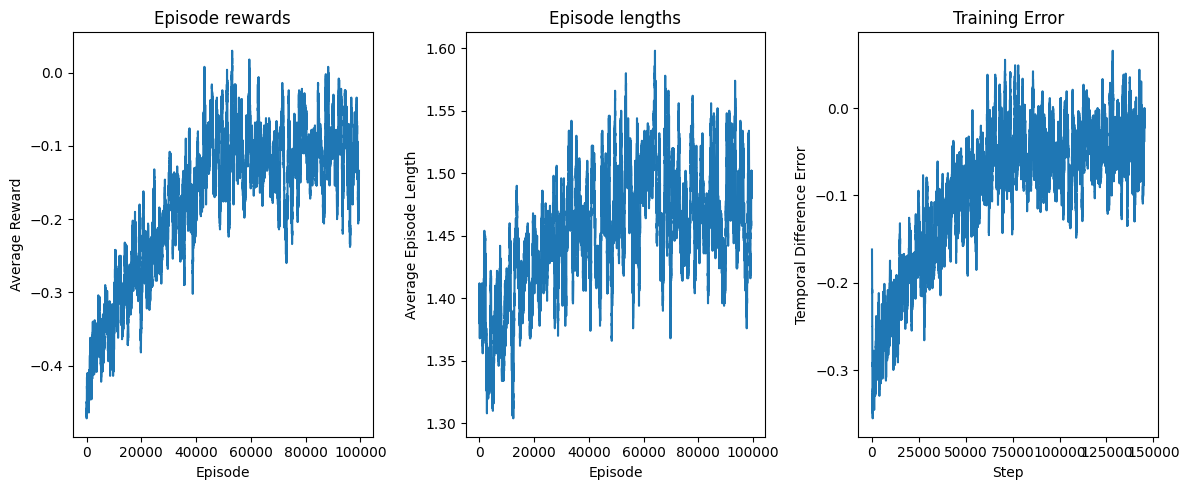

In [12]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [69]:
def test_agent(agent,env,num_epsiodes=1000):
    total_rewards=[]
    old_epsilon=agent.epsilon
    agent.epsilon=0
    for _ in tqdm(range(num_epsiodes)):
        obs,info=env.reset()
        episode_reward=0
        done=False
        while not done:
            action=agent.get_action(obs)
            obs,reward,terminated,truncated,info=env.step(action)
            episode_reward+=reward
            done=terminated or truncated
        total_rewards.append(episode_reward)
    agent.epsilon=old_epsilon

    win_rate=np.mean(np.array(total_rewards)>0)
    average_reward=np.mean(total_rewards)
    print(f"Episodes:{num_epsiodes}")
    print(f"Win rate:{win_rate}")
    print(f"Average reward:{average_reward}")
    print(f"Std deviation:{np.std(total_rewards)}")

In [70]:
test_agent(agent=agent,env=env)

100%|██████████| 1000/1000 [00:00<00:00, 8244.19it/s]

Episodes:1000
Win rate:0.405
Average reward:-0.094
Std deviation:0.9461310691442282
